In [4]:
import pandas as pd
import numpy as np
from datetime import datetime

# --- 1. Data Loading and Cleaning ---
try:
    df = pd.read_csv('combined_transactionsNew.csv')
    print("Successfully loaded 'combined_transactionsNew.csv'")
except FileNotFoundError:
    print("Error: 'combined_transactionsNew.csv' not found. Please ensure the file is in the correct directory.")
    exit()

df['DateTime (UTC)'] = pd.to_datetime(df['DateTime (UTC)'])
df['Value_IN(ETH)'] = pd.to_numeric(df['Value_IN(ETH)'], errors='coerce').fillna(0)
df['Value_OUT(ETH)'] = pd.to_numeric(df['Value_OUT(ETH)'], errors='coerce').fillna(0)
df['TxnFee(ETH)'] = pd.to_numeric(df['TxnFee(ETH)'], errors='coerce').fillna(0)
df['Status'].fillna('Success', inplace=True)

print("Data cleaning and preprocessing complete.")


# --- 2. Feature Engineering  ---
def calculate_features(wallet_txs):
    if wallet_txs.empty:
        return None

    num_txs = len(wallet_txs)
    days_active = (wallet_txs['DateTime (UTC)'].max() - wallet_txs['DateTime (UTC)'].min()).days + 1

    total_in = wallet_txs['Value_IN(ETH)'].sum()
    total_out = wallet_txs['Value_OUT(ETH)'].sum()
    total_value = total_in + total_out
    max_tx_value = max(wallet_txs['Value_IN(ETH)'].max(), wallet_txs['Value_OUT(ETH)'].max())

    risky_methods = ['Approve', 'Mint', 'Bid', 'Breed With Auto', 'Create Siring Auction']
    risky_tx_count = wallet_txs['Method'].isin(risky_methods).sum()

    current_time = datetime.now()
    days_since_last_tx = (current_time - wallet_txs['DateTime (UTC)'].max()).days

    failed_txs = wallet_txs[wallet_txs['Status'] != 'Success'].shape[0]

    features = {
        'num_transactions': num_txs,
        'tx_frequency': num_txs / days_active if days_active > 0 else 0,
        'total_value': total_value,
        'avg_tx_value': total_value / num_txs if num_txs > 0 else 0,
        'value_concentration': max_tx_value / total_value if total_value > 0 else 0,
        'total_gas': wallet_txs['TxnFee(ETH)'].sum(),
        'risky_tx_count': risky_tx_count,
        'days_since_last_tx': days_since_last_tx,
        'failed_txs': failed_txs
    }

    return pd.Series(features)

print("Calculating features for all wallets...")
features_df = df.groupby('wallet_address').apply(calculate_features)
print("Feature engineering complete.")


# --- 3. Risk Scoring ---
for column in features_df.columns:
    min_val = features_df[column].min()
    max_val = features_df[column].max()
    features_df[f'{column}_norm'] = (features_df[column] - min_val) / (max_val - min_val + 1e-6)

weights = {
    'num_transactions_norm': -0.10,
    'tx_frequency_norm': -0.10,
    'total_value_norm': -0.05,
    'avg_tx_value_norm': 0.05,
    'value_concentration_norm': 0.15,
    'total_gas_norm': -0.05,
    'risky_tx_count_norm': 0.25,
    'days_since_last_tx_norm': 0.15,
    'failed_txs_norm': 0.20
}

features_df['raw_score'] = 0
for feature, weight in weights.items():
    features_df['raw_score'] += features_df[feature] * weight

min_score = features_df['raw_score'].min()
max_score = features_df['raw_score'].max()
features_df['score'] = 1000 * (features_df['raw_score'] - min_score) / (max_score - min_score + 1e-6)
features_df['score'] = features_df['score'].astype(int)

print("Risk scoring complete.")

# --- 4. Output Generation ---
results_df = features_df[['score']].reset_index().rename(columns={'wallet_address': 'wallet_id'})

# Save the results to a CSV file.
results_df.to_csv('wallet_risk_scores_optimized.csv', index=False)

print("\nRisk scores calculated and saved to 'wallet_risk_scores_optimized.csv'")
print(results_df.head())

Successfully loaded 'combined_transactionsNew.csv'
Data cleaning and preprocessing complete.
Calculating features for all wallets...


/tmp/ipython-input-4-1141813143.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Status'].fillna('Success', inplace=True)


Feature engineering complete.
Risk scoring complete.

Risk scores calculated and saved to 'wallet_risk_scores_optimized.csv'
                                        wallet_id  score
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3 (1)    999
1  0x06b51c6882b27cb05e712185531c1f74996dd988 (1)    491
2  0x0795732aacc448030ef374374eaae57d2965c16c (1)    660
3      0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9    178
4      0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae    675


/tmp/ipython-input-4-1141813143.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = df.groupby('wallet_address').apply(calculate_features)


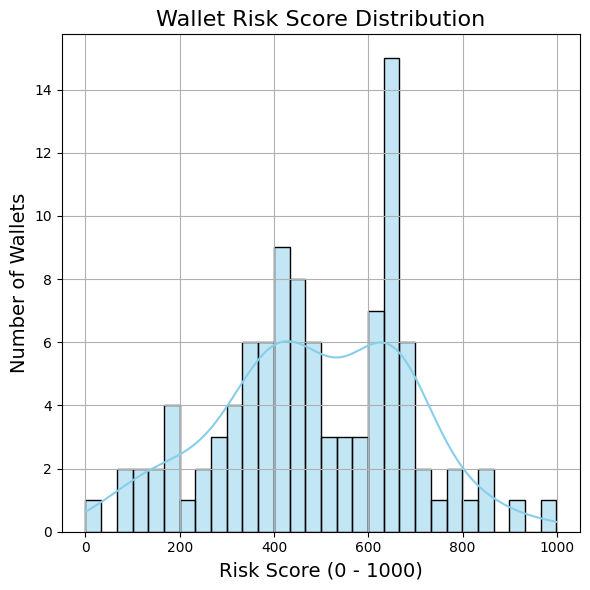

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.histplot(results_df["score"], bins=30, kde=True, color="skyblue", edgecolor="black")

plt.title("Wallet Risk Score ", fontsize=16)
plt.xlabel("Risk Score (0 - 1000)", fontsize=14)
plt.ylabel("Number of Wallets", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()